# Test the use of linear models to interpolate the gridded photo-z data
By Melissa Graham, University of Washington <br>
Saturday April 18, 2020 <br>
<br>
## Spoiler alert: they do not work.
Two approaches to interpolating in the 6-dimensional space of the 5-sigma limiting magnitude in each of the six LSST filters ugrizy are investigated in this notebook: scipy.interpolate griddata and LinearNDInterpolator, and sklearn.linear_model.LinearRegression.<br>
The take-way messages are: <br>
scipy's modules can be slow and prone to failure, and <br>
sklearn is very fast but not accurante enough. <br>
The failure of sklearn is illustrated also in the Jupyter Notebook "tutorial_on_failed_interpolation".<br>

In [1]:
import os
import numpy as np
from copy import deepcopy
import datetime
from scipy.interpolate import griddata, LinearNDInterpolator
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

## Demonstrate interpolation options.
Compare the use of scipy's interpolators to sklearn's linear regression model.

In [2]:
### Read in the data to be interpolated over:
###   zbi     = column corresponding to a redshift bin
###   maglims = all magnitude limits for all runs
###   stdd_z1 = standard deviation in a redshift bin

zbi = 13 # bin center = 1.50

### Read in the data from the file for standard deviation
maglims = np.loadtxt( 'grid_statistics/grid_stdd.dat', dtype='float', usecols=(0,1,2,3,4,5))
stdd_zb = np.loadtxt( 'grid_statistics/grid_stdd.dat', dtype='float', usecols={zbi})

### Set "user" input to be the baseline 5sigma magnitude limits
user_maglims = np.asarray( [26.09,27.38,27.53,26.83,26.05,24.86], dtype='float' )

### The baseline run results are in the first row of data
print('Standard deviation for the baseline run: ',stdd_zb[0])

### Optional, restrict the runs to only those nearby the user input
# user_maglims_6Ddist = np.sqrt( np.sum( (maglims-user_maglims)**2, axis=1 ) )
# tx = np.where( user_maglims_6Ddist < 1.0 )[0]
# print('Number of runs with a 6D dist within 1 mag: ',len(tx))
# temp1 = maglims[tx]
# temp2 = stdd_zb[tx]
# del maglims,stdd_zb
# maglims = temp1
# stdd_zb = temp2
# del temp1,temp2,tx

Standard deviation for the baseline run:  0.029578


### scipy

In [3]:
print(datetime.datetime.now())

print(' ')
### Use scipy.interpolate package's griddata function to interpolate with "nearest"
### https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html
results = griddata(maglims,stdd_zb,user_maglims,method='nearest')
print('scipy.interpolate.griddata using nearest: ',results[0])
print(datetime.datetime.now())

print(' ')
### Try instead with "linear" -- it is very slow and doesn't work for all user maglims
results2 = griddata(maglims,stdd_zb,user_maglims,method='linear')
print('scipy.interpolate.griddata using linear: ',results2[0])
print(datetime.datetime.now())

print(' ')
### Try the LinearNDInterpolator
results3 = LinearNDInterpolator(maglims,stdd_zb).__call__(user_maglims)
print('scipy.interpolate.LinearNDInterpolator: ',results3[0])
print(datetime.datetime.now())

print(' ')
print('scipy: too slow, although results are close to the true baseline results')
del results,results2,results3

2020-04-21 13:41:46.493856
 
scipy.interpolate.griddata using nearest:  0.028085
2020-04-21 13:41:46.495973
 
scipy.interpolate.griddata using linear:  0.029578
2020-04-21 13:41:53.445127
 
scipy.interpolate.LinearNDInterpolator:  0.029578
2020-04-21 13:42:00.873755
 
scipy: too slow, although results are close to the true baseline results


In [4]:
print('Try scipy again, but for input magnitudes that are further from the baseline.')
print('The second example is closer to a grid point, yet fails.')
print(' ')

### Use input mags 0.5mag fainter than the baseline
print('Example 1')
temp_umags = np.asarray( [25.5,26.7,27.0,26.3,25.5,24.3], dtype='float' )
temp = np.sort( np.sqrt( np.sum( (maglims-temp_umags)**2, axis=1 ) ) )
print('6D distance to nearest grid point = ',temp[0],' mag')
results = griddata(maglims,stdd_zb,temp_umags,method='nearest')
print('scipy.interpolate.griddata using nearest: ',results[0])
results2 = griddata(maglims,stdd_zb,temp_umags,method='linear')
print('scipy.interpolate.griddata using linear: ',results2[0])
results3 = LinearNDInterpolator(maglims,stdd_zb).__call__(temp_umags)
print('scipy.interpolate.LinearNDInterpolator: ',results3[0])
del temp_umags,temp,results,results2,results3

print(' ')

### Use a set of magnitudes very close to one of the runs
print('Example 2')
temp_umags = np.asarray( [25.6,27.3,27.5,27.0,25.4,25.1], dtype='float' )
temp = np.sort( np.sqrt( np.sum( (maglims-temp_umags)**2, axis=1 ) ) )
print('6D distance to nearest grid point = ',temp[0],' mag')
results = griddata(maglims,stdd_zb,temp_umags,method='nearest')
print('scipy.interpolate.griddata using nearest: ',results[0])
results2 = griddata(maglims,stdd_zb,temp_umags,method='linear')
print('scipy.interpolate.griddata using linear: ',results2[0])
results3 = LinearNDInterpolator(maglims,stdd_zb).__call__(temp_umags)
print('scipy.interpolate.LinearNDInterpolator: ',results3[0])
del temp_umags,temp,results,results2,results3

Try scipy again, but for input magnitudes that are further from the baseline.
The second example is closer to a grid point, yet fails.
 
Example 1
6D distance to nearest grid point =  0.233666428911  mag
scipy.interpolate.griddata using nearest:  0.043524
scipy.interpolate.griddata using linear:  0.0418149878643
scipy.interpolate.LinearNDInterpolator:  0.0418149878643
 
Example 2
6D distance to nearest grid point =  0.169410743461  mag
scipy.interpolate.griddata using nearest:  0.031176
scipy.interpolate.griddata using linear:  nan
scipy.interpolate.LinearNDInterpolator:  nan


### sklearn

In [5]:
print(datetime.datetime.now())

print(' ')
### Apply sklearn's linear_model LinearRegression
### https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
reg = linear_model.LinearRegression()
reg.fit(maglims,stdd_zb)
print("Coefficients: ", reg.coef_)
print("Intercept: ", reg.intercept_)
print('sklearn.linear_model.LinearRegression interpolate: ', reg.predict(user_maglims.reshape(1,-1))[0] )
print(datetime.datetime.now())

print(' ')
temp_umags = np.asarray( [25.5,26.7,27.0,26.3,25.5,24.3], dtype='float' )
print('Example 1')
print( reg.predict(temp_umags.reshape(1,-1))[0] )

print(' ')
temp_umags = np.asarray( [25.6,27.3,27.5,27.0,25.4,25.1], dtype='float' )
print('Example 2')
print( reg.predict(temp_umags.reshape(1,-1))[0] )

print(' ')
print('sklearn: appears to be very fast and pretty accurate and does not fail -- explore further below')
del reg

2020-04-21 13:42:28.079396
 
Coefficients:  [-0.00309272 -0.00164717 -0.00115167 -0.00325476 -0.00336505 -0.00426785]
Intercept:  0.469219337374
sklearn.linear_model.LinearRegression interpolate:  0.0306416573859
2020-04-21 13:42:28.084884
 
Example 1
0.0401626216222
 
Example 2
0.0329331032818
 
sklearn: appears to be very fast and pretty accurate and does not fail -- explore further below


In [6]:
### Clean up from the demonstrations above
del user_maglims,maglims,stdd_zb,zbi

## Attempt to validate sklearn.linear_model.LinearRegression
Interpolate the standard deviation, bias, and fraction of outliers at every 6D grid point, and calculate the difference between the interpolate and the true value. Plot the difference as a function of the 6D distance of that grid point from the baseline run and from its next-nearest neighbor grid point, for three redshifts: 0.6 (low), 1.2 (intermediate), and 2.1 (high).

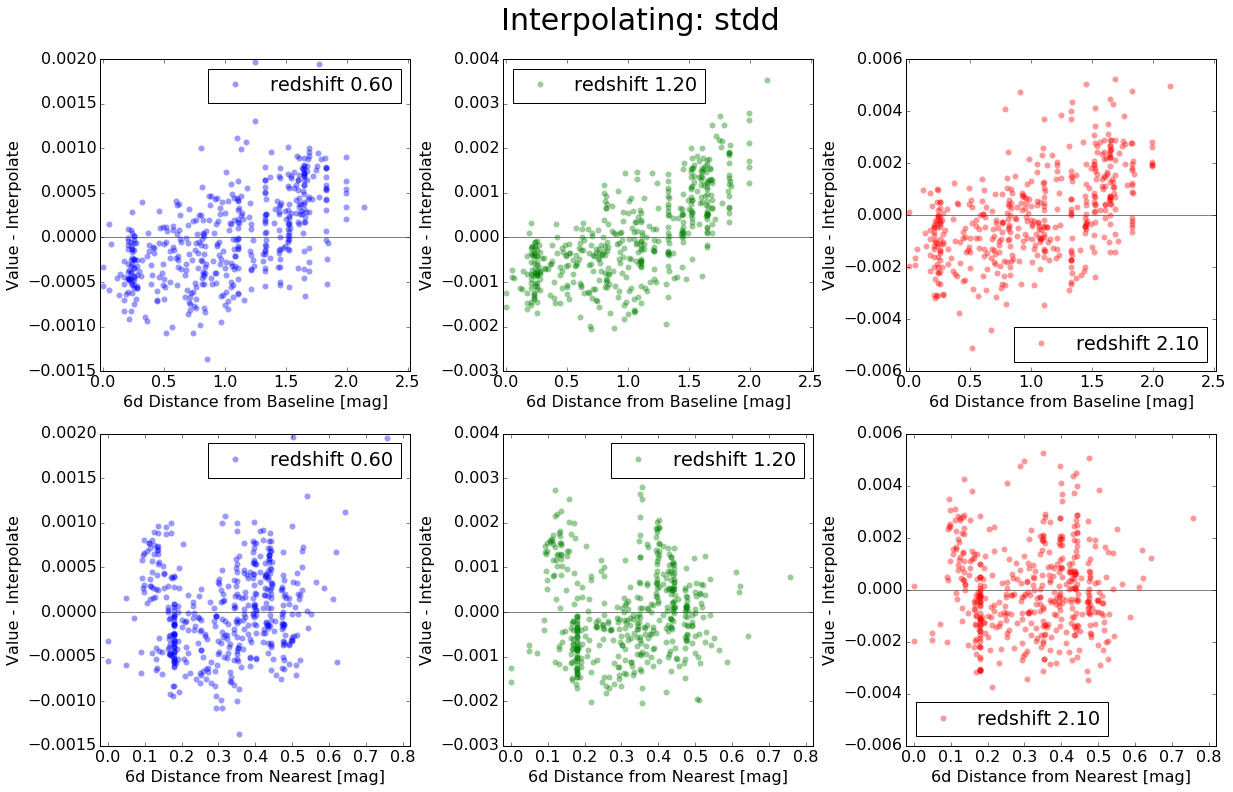

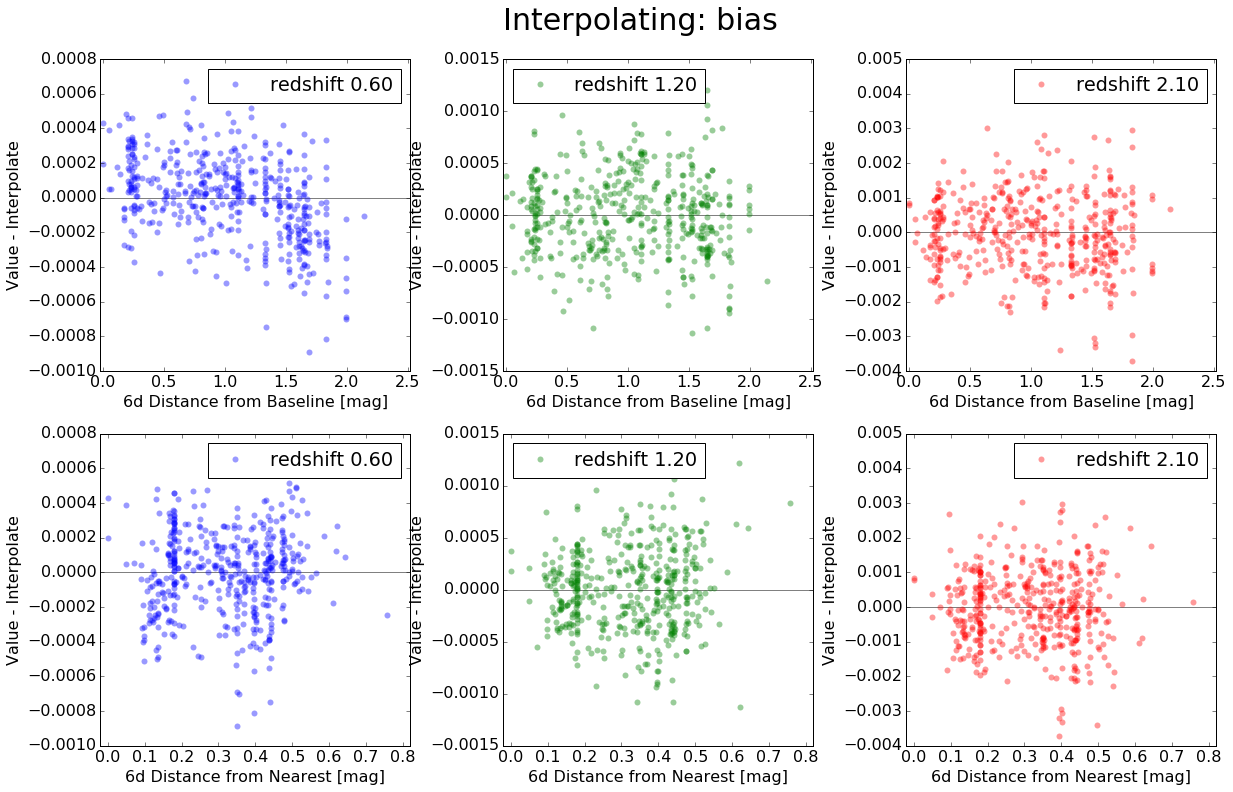

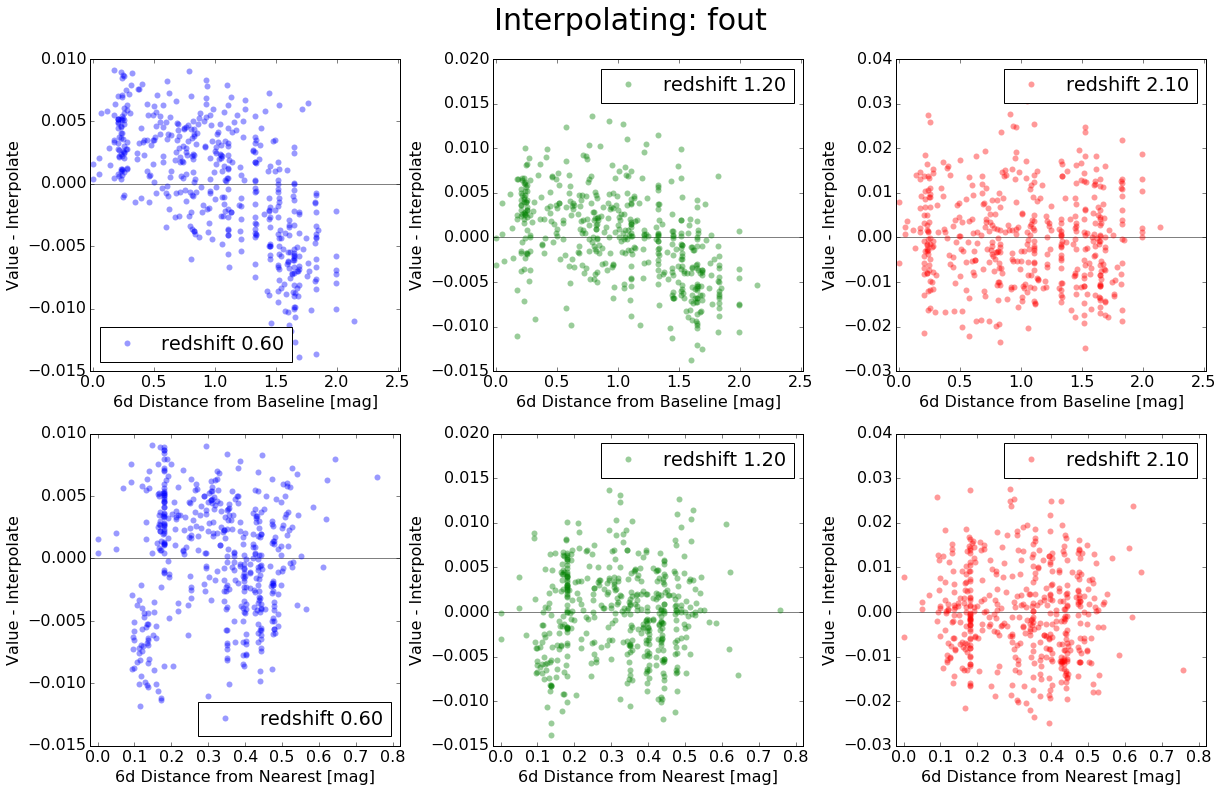

In [7]:
stat_names = ['stdd','bias','fout']

zbi_low = 7
zbi_int = 11
zbi_hi  = 17
str_zlow = '0.60'
str_zint = '1.20'
str_zhi  = '2.10'

for s,stat in enumerate(stat_names):
    
    ### Read in the grid of data for this statistic
    maglims = np.loadtxt( 'grid_statistics/grid_'+stat+'.dat', dtype='float', usecols=(0,1,2,3,4,5))
    stat_zlow = np.loadtxt( 'grid_statistics/grid_'+stat+'.dat', dtype='float', usecols={zbi_low})
    stat_zint = np.loadtxt( 'grid_statistics/grid_'+stat+'.dat', dtype='float', usecols={zbi_int})
    stat_zhi  = np.loadtxt( 'grid_statistics/grid_'+stat+'.dat', dtype='float', usecols={zbi_hi})

    ### Train the linear models
    reg_zlow = linear_model.LinearRegression()
    reg_zlow.fit(maglims,stat_zlow)
    reg_zint = linear_model.LinearRegression()
    reg_zint.fit(maglims,stat_zint)
    reg_zhi = linear_model.LinearRegression()
    reg_zhi.fit(maglims,stat_zhi)

    ### Create arrays for 6D distance and the difference = interpolate - true value
    maglims_6Ddist_baseline = np.zeros( len(maglims), dtype='float' )
    maglims_6Ddist_nearest = np.zeros( len(maglims), dtype='float' )
    diff_stat_zlow = np.zeros( len(maglims), dtype='float' )
    diff_stat_zint = np.zeros( len(maglims), dtype='float' )
    diff_stat_zhi  = np.zeros( len(maglims), dtype='float' )

    for i in range(len(maglims)):        
        maglims_6Ddist_baseline[i] = np.sqrt( np.sum( (maglims[0]-maglims[i])**2 ) )
        temp = np.sort( np.sqrt( np.sum( (maglims-maglims[i])**2, axis=1 ) ) )
        maglims_6Ddist_nearest[i]  = temp[1]
        del temp
        diff_stat_zlow[i] = stat_zlow[i] - reg_zlow.predict(maglims[i].reshape(1, -1))
        diff_stat_zint[i] = stat_zint[i] - reg_zint.predict(maglims[i].reshape(1, -1))
        diff_stat_zhi[i]  = stat_zhi[i]  - reg_zhi.predict(maglims[i].reshape(1, -1))

    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(20,12) )
    plt.rcParams.update( {'font.size':16} )

    ax1.axhline(0.0,color='grey')
    ax1.plot(maglims_6Ddist_baseline,diff_stat_zlow,'o',mew=0,alpha=0.4,color='blue',label='redshift '+str_zlow)
    ax1.set_xlabel('6d Distance from Baseline [mag]')
    ax1.set_xlim([-0.02,2.52])
    ax1.set_ylabel('Value - Interpolate')
    ax1.legend(loc='best', numpoints=1)

    ax2.axhline(0.0,color='grey')
    ax2.plot(maglims_6Ddist_baseline,diff_stat_zint,'o',mew=0,alpha=0.4,color='green',label='redshift '+str_zint)
    ax2.set_xlabel('6d Distance from Baseline [mag]')
    ax2.set_xlim([-0.02,2.52])
    ax2.set_ylabel('Value - Interpolate')
    ax2.legend(loc='best', numpoints=1)

    ax3.axhline(0.0,color='grey')
    ax3.plot(maglims_6Ddist_baseline,diff_stat_zhi,'o',mew=0,alpha=0.4,color='red',label='redshift '+str_zhi)
    ax3.set_xlabel('6d Distance from Baseline [mag]')
    ax3.set_xlim([-0.02,2.52])
    ax3.set_ylabel('Value - Interpolate')
    ax3.legend(loc='best', numpoints=1)

    ax4.axhline(0.0,color='grey')
    ax4.plot(maglims_6Ddist_nearest,diff_stat_zlow,'o',mew=0,alpha=0.4,color='blue',label='redshift '+str_zlow)
    ax4.set_xlabel('6d Distance from Nearest [mag]')
    ax4.set_xlim([-0.02,0.82])
    ax4.set_ylabel('Value - Interpolate')
    ax4.legend(loc='best', numpoints=1)

    ax5.axhline(0.0,color='grey')
    ax5.plot(maglims_6Ddist_nearest,diff_stat_zint,'o',mew=0,alpha=0.4,color='green',label='redshift '+str_zint)
    ax5.set_xlabel('6d Distance from Nearest [mag]')
    ax5.set_xlim([-0.02,0.82])
    ax5.set_ylabel('Value - Interpolate')
    ax5.legend(loc='best', numpoints=1)

    ax6.axhline(0.0,color='grey')
    ax6.plot(maglims_6Ddist_nearest,diff_stat_zhi,'o',mew=0,alpha=0.4,color='red',label='redshift '+str_zhi)
    ax6.set_xlabel('6d Distance from Nearest [mag]')
    ax6.set_xlim([-0.02,0.82])
    ax6.set_ylabel('Value - Interpolate')
    ax6.legend(loc='best', numpoints=1)

    plt.subplots_adjust(wspace=0.3,top = 0.92)
    plt.suptitle('Interpolating: '+stat, fontsize=30)
    plt.show()

    del maglims,stat_zlow,stat_zint,stat_zhi
    del reg_zlow,reg_zint,reg_zhi
    del maglims_6Ddist_baseline,maglims_6Ddist_nearest
    del diff_stat_zlow,diff_stat_zint,diff_stat_zhi

del stat_names
del zbi_low,zbi_int,zbi_hi,str_zlow,str_zint,str_zhi

We can see from the above plots that the interpolated values from sklearn are not as accurate as they seemed and that there are trends with the distance from the baseline and distance from the next-nearest-neighbor in the grid of data.

# Summary

scipy.interpolate -- "linear" and "LinearNDInterpolator" are slow and fail when they shouldn't.<br>
sklearn.linear_model -- is very fast but does not do a good enough job of interpolation
